# Analysis of the Distribution and Variation of Temperatures in the Contiguous 48 States
Jessica Embury

# MERGE NOAA & CDC DATA INTO SHAPEFILE FOR USE IN R ANALYSIS, ARCGIS PRO

In [ ]:
#import modules
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Polygon
from shapely.geometry import Point

#modules for visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import geoplot

In [2]:
#create geodataframe from noaa temperature point shapefile
noaa_path = 'output/shapefiles/gsoy_temps.shp'
noaa = gpd.read_file(noaa_path)

In [3]:
#create geodataframe from county polygon shapefile, also contains cdc heat-death info per county
cdc_path = 'output/shapefiles/heatdeath_county.shp'
cdc = gpd.read_file(cdc_path)

In [4]:
#subset dataframes for determining noaa temperature data at the county level

#number days above 90F per station
dx90 = noaa[['station','DX90','geometry']]

#extreme maximum temperature per station
ext_max = noaa[['station','EMXT','geometry']]

#spatial county information
county = cdc[['GEOID','NAME','geometry']]

In [5]:
#assign counties to dx90 gdf
dx90_counties = sjoin(dx90, county, how='left')

In [6]:
dx90_counties.head()

,station,DX90,geometry,index_right,GEOID,NAME
0,GHCND:CA001018611,8.0,POINT (-123.3333 48.0333),1302,53009,Clallam
1,GHCND:CA001135126,385.0,POINT (-118.7667 49),1758,53019,Ferry
2,GHCND:CA006020559,20.0,POINT (-93.9667 48.6333),591,27071,Koochiching
3,GHCND:USC00010160,972.0,POINT (-85.94799999999999 32.9452),1932,01123,Tallapoosa
4,GHCND:USC00010390,834.0,POINT (-86.9508 34.7752),780,01083,Limestone


In [7]:
#find the mean number of days above 90F per county
max_dx90 = dx90_counties[['DX90','GEOID']].groupby('GEOID').max().reset_index()

print(len(max_dx90))
max_dx90.head()

2682


,GEOID,DX90
0,01003,1558.0
1,01005,1021.0
2,01007,1182.0
3,01009,67.0
4,01011,895.0


In [8]:
#Merge mean_dx90 to original cdc gdf
cdc2 = cdc.merge(max_dx90, on = 'GEOID')

In [9]:
#assign counties to ext_max gdf
max_counties = sjoin(ext_max, county, how='left')

In [10]:
#find absolute maximum temperature per county
county_max = max_counties[['EMXT','GEOID']].groupby('GEOID').max().reset_index()
county_max.head()

,GEOID,EMXT
0,01003,106.0
1,01005,106.0
2,01007,114.0
3,01009,97.0
4,01011,102.0


In [11]:
#Merge county_max to original cdc gdf
cdc3 = cdc2.merge(county_max, on = 'GEOID')
cdc3.head()

,STATEFP,COUNTYFP,GEOID,NAME,County,CAUSE_DEAT,Deaths,Population,CDR,RELIABLE,geometry,DX90,EMXT
0,31,039,31039,Cuming,None,None,0.0,NaN,0.0,None,"POLYGON ((-97.019516 42.004097, -97.019519 42....",388.0,101.0
1,35,011,35011,De Baca,None,None,0.0,NaN,0.0,None,"POLYGON ((-104.567387 33.997566, -104.567717 3...",1074.0,108.0
2,31,109,31109,Lancaster,None,None,0.0,NaN,0.0,None,"POLYGON ((-96.91059899999999 40.958407, -96.91...",809.0,108.0
3,31,129,31129,Nuckolls,None,None,0.0,NaN,0.0,None,"POLYGON ((-98.27366699999999 40.089399, -98.27...",634.0,106.0
4,46,099,46099,Minnehaha,None,None,0.0,NaN,0.0,None,"POLYGON ((-97.129283 43.58682599999999, -97.12...",275.0,105.0


In [12]:
#calculate percent of days above 90F
#total days in study period = 6574

cdc3['dx90_percent'] = cdc3['DX90']/6574*100
cdc3.head()

,STATEFP,COUNTYFP,GEOID,NAME,County,CAUSE_DEAT,Deaths,Population,CDR,RELIABLE,geometry,DX90,EMXT,dx90_percent
0,31,039,31039,Cuming,None,None,0.0,NaN,0.0,None,"POLYGON ((-97.019516 42.004097, -97.019519 42....",388.0,101.0,5.902038
1,35,011,35011,De Baca,None,None,0.0,NaN,0.0,None,"POLYGON ((-104.567387 33.997566, -104.567717 3...",1074.0,108.0,16.337085
2,31,109,31109,Lancaster,None,None,0.0,NaN,0.0,None,"POLYGON ((-96.91059899999999 40.958407, -96.91...",809.0,108.0,12.306054
3,31,129,31129,Nuckolls,None,None,0.0,NaN,0.0,None,"POLYGON ((-98.27366699999999 40.089399, -98.27...",634.0,106.0,9.644052
4,46,099,46099,Minnehaha,None,None,0.0,NaN,0.0,None,"POLYGON ((-97.129283 43.58682599999999, -97.12...",275.0,105.0,4.183146


In [13]:
#keep only pertinent information in subset
heat = cdc3[['GEOID','NAME','CAUSE_DEAT','Deaths','CDR','EMXT','dx90_percent','geometry']]

#give columns more meaningful names
heat = heat.rename(columns = {'NAME':'County','CAUSE_DEAT':'ICD10','EMXT':'Max_Temp','dx90_percent':'Percent90'})
heat.head()

,GEOID,County,ICD10,Deaths,CDR,Max_Temp,Percent90,geometry
0,31039,Cuming,None,0.0,0.0,101.0,5.902038,"POLYGON ((-97.019516 42.004097, -97.019519 42...."
1,35011,De Baca,None,0.0,0.0,108.0,16.337085,"POLYGON ((-104.567387 33.997566, -104.567717 3..."
2,31109,Lancaster,None,0.0,0.0,108.0,12.306054,"POLYGON ((-96.91059899999999 40.958407, -96.91..."
3,31129,Nuckolls,None,0.0,0.0,106.0,9.644052,"POLYGON ((-98.27366699999999 40.089399, -98.27..."
4,46099,Minnehaha,None,0.0,0.0,105.0,4.183146,"POLYGON ((-97.129283 43.58682599999999, -97.12..."


In [14]:
#export gdf with cdc death info and temp info per county as shapefile
shapefile_out_path = 'output/shapefiles/heat.shp'
heat.to_file(driver = "ESRI Shapefile", filename = shapefile_out_path)

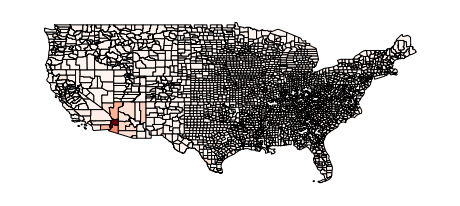

In [15]:
#County choropleth with death rate/1000 selected as the attribute for hue
geoplot.choropleth(heat, hue = 'CDR', cmap = 'Reds')

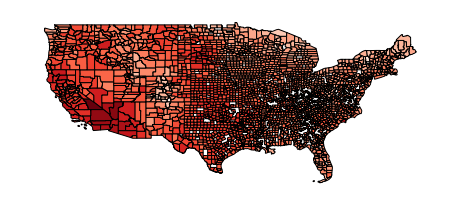

In [16]:
#County choropleth with max temperature selected as the attribute for hue
geoplot.choropleth(heat, hue = 'Max_Temp', cmap = 'Reds')

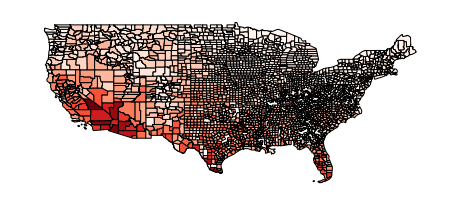

In [17]:
#County choropleth with percent of days above 90F selected as the attribute for hue
geoplot.choropleth(heat, hue = 'Percent90', cmap = 'Reds')